# Packages

In [1]:
import math
import numpy as np
import pandas as pd
from scipy.special import lambertw, erf
from scipy.optimize import root
from scipy.optimize import basinhopping
from scipy.optimize import least_squares, minimize_scalar

from scipy.stats import pearsonr

import matplotlib.cm as cm
from shapely.geometry import Polygon
from descartes import PolygonPatch

import pickle 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

fs = 7
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : fs}

# use this for all helvetica
from matplotlib import pyplot as plt
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helvetica'] # Choose a nice font here

# use this with the example below to have more control
# from matplotlib import pyplot as plt
# plt.rc('text', usetex=True)
# plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})


<ipython-input-1-534d606f625b>:28: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)


# Functions

In [2]:
def u_calc_guo(z,u_s,d,nu):
    zp = z*u_s/nu
    dp = d*u_s/nu
    
    kappa = 0.4
    b = 1./kappa*np.log(9.)
    c = np.exp(kappa*(16.873-b))
    
    return u_s*(7.*np.arctan(zp/7.)+7./3.*np.arctan(zp/7.)**3.-0.52*np.arctan(zp/7.)**4.+np.log(1.+(zp/c)**(1./kappa))-np.log(1.+0.3*dp*(1.-np.exp(-dp/26.)))/kappa)

###################################
###################################
###################################

def Cl_calc_loth(d,u_s,nu):
    u = u_calc_guo(d/2.,u_s,d,nu)
    rep = u*d/nu
    w = (u_calc_guo(d,u_s,d,nu)-0.)/(d-0.)
    w_s = w*d/u
    x = w_s/rep
    
    cl_saff = 12.92/np.pi*x**0.5
    j_s = 0.443*0.6765*(1.+np.tanh(2.5*np.log10(x**0.5+0.191)))*(0.667+np.tanh(6.*(x**0.5-0.32))) #written wrong in loth, also referenced to the wrong mei paper, see mei1992.pdf for correct expression used here
    cl0 = cl_saff*j_s
        
    cl1 = -w_s**(1./3.)*(0.0525+0.0575*np.tanh(5.*np.log10(rep/120.)))
    
    cl = np.empty_like(rep)
    
    cl[rep<=50.] = cl0[rep<=50.]
    cl[rep>50.]  = cl1[rep>50.]
    
    return cl

def Cd_calc_loth(Re,Ma,gamma):
    Kn = Ma/Re*(np.pi*gamma/2.)**0.5
    
    Cm = np.empty_like(Ma)
    Cm[(Re>45.)&(Ma<1.45)]  = 5./3.+2./3.*np.tanh(3.*np.log(Ma[(Re>45.)&(Ma<1.45)]+0.1))
    Cm[(Re>45.)&(Ma>=1.45)] = 2.044+0.2*np.exp(-1.8*np.log(Ma[(Re>45.)&(Ma>=1.45)]/1.5)**2.)
    
    Gm = np.empty_like(Ma)
    Gm[(Re>45.)&(Ma<0.89)]  = 1.-1.525*Ma[(Re>45.)&(Ma<0.89)]**4.
    Gm[(Re>45.)&(Ma>=0.89)] = 0.0002 + 0.0008*np.tanh(12.77*(Ma[(Re>45.)&(Ma>=0.89)]-2.02))
    
    Hm = np.empty_like(Ma)
    Hm[(Re>45.)] = 1.-0.258*Cm[(Re>45.)]/(1.+514.*Gm[(Re>45.)])
    
    #####
    
    s = Ma*(gamma/2.)**0.5
    Cdfmp = (1.+2.*s**2.)*np.exp(-s**2.)/s**3./np.pi**0.5+(4.*s**4.+4.*s**2.-1)*erf(s)/2./s**4.+2./3./s*np.pi**0.5
    CdfmRe = Cdfmp/(1.+(Cdfmp/1.63-1.)*(Re/45.)**0.5)
    fKn = 1./(1.+Kn*(2.514+0.8*np.exp(-0.55/Kn)))
    CdKnRe = 24./Re*(1.+0.15*Re**0.687)*fKn
    
    #####
    
    Cd = np.empty_like(Ma)
    Cd[(Re>45.)] = 24./Re[(Re>45.)]*(1.+0.15*Re[(Re>45.)]**0.687)*Hm[(Re>45.)]+0.42*Cm[(Re>45.)]/(1.+42500.*Gm[(Re>45.)]/Re[(Re>45.)]**1.16)
    Cd[(Re<=45.)] = (CdKnRe[(Re<=45.)]+Ma[(Re<=45.)]**4.*CdfmRe[(Re<=45.)])/(1.+Ma[(Re<=45.)]**4.)

    return Cd

def Cd_calc_camenen(Re):
    # Ma not used
    
    A = 24.
    B = 1.
    m = 1.5
    
    return ((A/Re)**(1./m)+B**(1./m))**m

###################################
###################################
###################################

def us_calc_iverson(d,g,rhop,rhof,nu):
    
    def func_iverson(us,d,g,rhop,rhof,nu):
        rep = us*d/nu

        X = 0.006/1000./10.
        
        a = np.empty_like(rep)
        a[(rep>0.003)&(rep<=10.)] = 0.129*((1.+X/rhop[(rep>0.003)&(rep<=10.)]/g[(rep>0.003)&(rep<=10.)]/d[(rep>0.003)&(rep<=10.)]**2.5)/(1.928*rep[(rep>0.003)&(rep<=10.)]**0.092-1.))**0.5
        a[(rep>10.)] = 0.120*(1.+X/rhop[(rep>10.)]/g[(rep>10.)]/d[(rep>10.)]**2.5)**0.5*(1.-0.0858*np.exp(-0.0671*(rep[(rep>10.)]-10.)))
        a[(rep<0.003)] = np.nan
#         a[(rep<0.003)] = 0.129*((1.+X/rhop[(rep>0.003)&(rep<=10.)]/g[(rep>0.003)&(rep<=10.)]/d[(rep>0.003)&(rep<=10.)]**2.5)/(1.928*rep[(rep>0.003)&(rep<=10.)]**0.092-1.))**0.5

        return a*(rhop*g*d/rhof)**0.5-us
    
    return root(func_iverson, 1e+3*d/d, (d,g,rhop,rhof,nu)).x

def us_calc_shao(d,g,rhop,rhof):
    An = 0.0123
    gamma = 3e-4
    return (An*(rhop/rhof*g*d+gamma/rhof/d))**0.5

###################################
###################################
###################################

def lj1(T,constants1):
    sigma,eps_div_kb,M = constants1[0]
    Ts = T/eps_div_kb
    # omega from neufeld 1972
    omega = 1.16145*Ts**-0.14874+0.52487*np.exp(-0.77320*Ts)+2.16178*np.exp(-2.43787*Ts)
    return 2.6693e-6*(M*T)**0.5/sigma**2/omega

def ljm(T,constantsm):
    mum = 0
    for i in range(len(constantsm)):
        xi = constantsm[i][-1]
        Mi = constantsm[i][2]
        mui = lj1(T,[constantsm[i][:-1]])
        denom = 0
        for j in range(len(constantsm)):
            xj = constantsm[j][-1]
            Mj = constantsm[j][2]
            muj = lj1(T,[constantsm[j][:-1]])
            phiij = (1.+(mui/muj)**0.5*(Mi/Mj)**0.25)**2./(1.+Mi/Mj)**0.5/8.**0.5
            denom = denom + xj*phiij
        mum = mum + xi*mui/denom
    return mum

def lj(T,constants):
    if len(constants)==1:
        return lj1(T,constants)
    else:
        return ljm(T,constants) 

def igl1(T,p,constants1):
    M = constants1[0][2]*1e-3 #g/mol to kg/mol
    return p*M/R/T

def iglm(T,p,constantsm):
    M = 0.
    for i in range(len(constantsm)):
        M = M + constantsm[i][2]*constantsm[i][3]
    M = M*1e-3
    return p*M/R/T

def igl(T,p,constants):
    if len(constants)==1:
        return igl1(T,p,constants)
    else:
        return iglm(T,p,constants) 

def ktg1(T,p,constants1):
    M  = constants1[0][2]*1e-3
    mu = lj1(T,constants1)
    return mu/p*(np.pi*R*T/2./M)**0.5

def ktgm(T,p,constantsm):
    M = 0.
    for i in range(len(constantsm)):
        M = M + constantsm[i][2]*constantsm[i][3]
    M = M*1e-3
    mu = ljm(T,constantsm)
    return mu/p*(np.pi*R*T/2./M)**0.5

def ktg(T,p,constants):
    if len(constants)==1:
        return ktg1(T,p,constants)
    else:
        return ktgm(T,p,constants)     

###################################
###################################
###################################

def vdw_calc_hamaker(A,d,D):
    R = d/2.
    return A/6.*(64.*R**6./D**2./(2.*R+D)**3./(4.*R+D)**2.)

def n_calc_vT(T,n1,T1,n2,T2): # for solids
    m = (n2-n1)/(T2-T1)
    return m*(T-T1)+n1

def n_calc_vTp(T,p,n1,T1,p1,n2,T2,p2): # for gases
    # 3 points define a flat plane, n3,T3,p3 = 1,any,0
    a = (n1-1-p1*(n2-1)/p2)/(T1-p1*T2/p2)
    b = (n2-1-a*T2)/p2
    return a*T+b*p+1

def A_calc_lifshitz(T,eps_s,n_s,eps_f,n_f):
    ve = c_light/1e-7
    return 3./4.*kb*T*((eps_s-eps_f)/(eps_s+eps_f))**2.+3.*h*ve/16./2.**0.5*(n_s**2.-n_f**2.)**2./(n_s**2.+n_f**2.)**1.5

In [3]:
def find_rhs(a,b,d,rho_f,rho_s,A,g):
    surfgam = A/12./np.pi/d0**2.
    s = rho_s/rho_f
    rhs = 4./3.*g*d*(s-1.)/a + 4.*6.**0.5*surfgam/d/rho_f*np.exp(-b)/a
    return rhs

def find_u(u_s,a,b,d,rho_f,rho_s,A,nu,T,g,gamma,M):
    u  = u_calc_guo(d/2.,u_s,d,nu)
    cd = Cd_calc_loth(u*d/nu,u/(gamma*R*T/M)**0.5,gamma)
    cl = Cl_calc_loth(d,u_s,nu)
    C = 2.*2**0.5*cd+cl
    target = np.abs((find_rhs(a,b,d,rho_f,rho_s,A,g)/(C+0j))**0.5)
    return u-target

def find_us_fl(a,b,d,rho_f,rho_s,A,nu,T,g,gamma,M,*args):
    s = rho_s/rho_f
    t0 = (1e+2/((d*g*(s-1)/s)**(1./4.)/nu**(1./2.)))
    if args:
        t0 = args[0]
    sol = root(find_u,t0,(a,b,d,rho_f,rho_s,A,nu,T,g,gamma,M),method='krylov')
    return sol.x

In [4]:
def net_forces(u_s,a,b,d,rho_f,rho_s,A,nu,T,g,gamma,M):

    u  = u_calc_guo(d/2.,u_s,d,nu)
    Ma = u/(gamma*R*T/M)**0.5
    Re = u*d/nu
    Cd = Cd_calc_loth(Re,Ma,gamma)
    Cl = Cl_calc_loth(d,u_s,nu)

    Fgr = rho_s*np.pi/6.*d**3.*g
    Fbu = rho_f*np.pi/6.*d**3.*g
    Fli = rho_f*np.pi/8.*Cl*d**2.*u**2.
    Fdr = rho_f*np.pi/8.*Cd*d**2.*u**2.
    Fad = A*d/24./d0**2.*np.exp(-b)

    Rgr = d/4./3.**0.5
    Rbu = d/4./3.**0.5
    Rli = d/4./3.**0.5
    Rdr = d/6.**0.5
    Rad = d/2./2.**0.5

    return (a*(Rdr*Fdr+Rli*Fli)+Rbu*Fbu)-(Rgr*Fgr+Rad*Fad)
    
def calc_us_for_find_ab(a,b,d,rho_f,rho_s,A,nu,T,g,gamma,M):
    # use this tempscale as the initial guess because the solution must be approached from above starting at
    # a value reasonably proportional to the solution. here i exploit that to first order, Ga*s^(1/2)=1/Sh
    # to approximate 100x the expected answer as the place to start converging from.
    s = rho_s/rho_f
    tempscale = 5e+1/((d*g*(s-1.)/s)**(1./4.)/nu**(1./2.))
    
    return root(net_forces, tempscale, (a,b,d,rho_f,rho_s,A,nu,T,g,gamma,M)).x

def find_ab(fittingparams,u_s_obs,d,rho_f,rho_s,A,nu,T,g,gamma,M):
    u_s_pred = np.empty(len(u_s_obs))
    a,b = fittingparams
    u_s_pred = calc_us_for_find_ab(a,b,d,rho_f,rho_s,A,nu,T,g,gamma,M)
    return u_s_obs/u_s_pred - 1.

def find_b(fittingparam,u_s_obs,d,rho_f,rho_s,A,nu,T,g,gamma,M):
    u_s_pred = np.empty(len(u_s_obs))
    a = 1
    b = fittingparam
    u_s_pred = calc_us_for_find_ab(a,b,d,rho_f,rho_s,A,nu,T,g,gamma,M)
    return u_s_obs/u_s_pred - 1.

# Constants

In [5]:
R  = 8.314462
kb = 1.381e-23
h  = 6.626e-34
kappa = 0.412
c_light = 299792458
d0 = 0.165e-9

In [6]:
# sigma, eps_div_kb, M, x

lj_constants_ea = [[3.617, 97. ,28.964]] # Air
lj_constants_ma = [[3.996,190. ,44.01 ,0.953], # CO2
                   [3.667, 99.8,28.013,0.027], # N2
                   [3.432,122.4,39.948,0.016]] # Ar
lj_constants_ti = [[3.617, 99.8,28.013,0.953], # N2
                   [3.78 ,154. ,16.04 ,0.047]] # CH4
lj_constants_ve = [[3.996,190. ,44.01 ,0.965], # CO2
                   [3.617, 99.8,28.013,0.035]] # N2
lj_constants_pl = [[3.617, 99.8,28.013]] # N2
lj_constants_tr = [[3.617, 99.8,28.013]] # N2

gamma_ea = 1.40
gamma_ma = 1.31
gamma_ti = 1.47
gamma_ve = 1.235
gamma_pl = 1.47
gamma_tr = 1.47

g_ea = 9.81
g_ma = 3.73
g_ti = 1.36
g_ve = 8.88
g_pl = 0.62
g_tr = 0.78

p_ea = [   98200. ,  104900. ]
p_ma = [     500. ,     750. ]
p_ti = [  149526. ,  149759. ]
p_ve = [ 4500000. ,11000000. ]
p_pl = [       1. ,       1.1]
p_tr = [       1.5,       1.9]

T_ea = [270.,320.]
T_ma = [143.,265.]
T_ti = [ 90., 94.]
T_ve = [650.,755.]
T_pl = [ 37., 55.]
T_tr = [ 43., 53.]

nu_reported_ea = [1.5e-5,3.2e-5]
nu_reported_ma = [5.4e-4,6.0e-4,1.0e-3]
nu_reported_ti = [1.235e-6]
nu_reported_ve = [2.50e-7,4.85e-7]
nu_reported_pl = [2e-2]
nu_reported_tr = [4.5e-2]

rho_f_reported_ea = [1.2e+0]
rho_f_reported_ma = [1.5e-2,2.0e-2]
rho_f_reported_ti = [5.1e+0]
rho_f_reported_ve = [3.6e+1,7.4e+1]
rho_f_reported_pl = [9.1e-5]
rho_f_reported_tr = [1.4e-4]

rho_s_ea = [2650.,2380.] # SiO2, CaSO4.2*H2O
rho_s_ma = [3000.,2650.] # Basalt, SiO2
rho_s_ti = [1400., 400., 950.] # Tholin, Tholin eff, H2O
rho_s_ve = [3000.,2650.] # Basalt, various
rho_s_pl = [ 470., 940.] # CH4, N2 
rho_s_tr = [1400., 400., 470., 940.] # Tholin, Tholin eff, CH4, N2

In [7]:
# VAN DER WAALS STUFF

# try get values for n at different temps and pressures close to planet conditions
# at reference wavelengths of 
# 589.29 nm (visible) i.e. 6e-7 m wavelength, 5e+14 1/s frequency
# 100 nm (UV) i.e. 1e-7 m wavelength, 3e+15 1/s frequency

# SOLIDS
# n, wavelength (m), temperature (K)
ns_CH4_1  = [1.3310,6.328e-7,30] #https://doi.org/10.1364/AO.33.008306
ns_CH4_2  = [1.3210,6.328e-7,90] #https://doi.org/10.1364/AO.33.008306
ns_SiO2_1 = [1.4575,6.328e-7,300] #https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20070018851.pdf
ns_SiO2_2 = [1.4566,6.328e-7,180] #https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20070018851.pdf
ns_Gyps_1 = [1.5218,5.730e-7,273.15+12] #https://www.jstor.org/stable/92960
ns_Gyps_2 = [1.5190,5.730e-7,273.15+105] #https://www.jstor.org/stable/92960
ns_Basa_1 = [1.5690,5.900e-7,273.15+23] #https://doi.org/10.1007/s002690050085
ns_Basa_2 = [1.5691,5.900e-7,273.15+2500] # can't find anything so assuming no T dependence :(
ns_H2O_1  = [1.2603,6.328e-7,90] #https://doi.org/10.3847/1538-4357/ab0d89
ns_H2O_2  = [1.2464,6.328e-7,70] #https://doi.org/10.3847/1538-4357/ab0d89
ns_N2_1   = [1.22,6.328e-7,22] #https://doi.org/10.1016/j.pss.2008.07.015
ns_N2_2   = [1.20,6.328e-7,10] #https://doi.org/10.1016/j.pss.2008.07.015
# static relative permittivity i.e. the dialectric constant at frequency = 0
eps_CH4   = 1.725 #80K # https://doi.org/10.1063/1.1724850
eps_SiO2   = 3.8 #isrealachvilli
eps_Gyps   = 5.7 #file:///home/andrew/Downloads/pdfhall.com_265-dielectric-properties-of-materials_5b397fa5097c47f3488b4580.pdf
eps_Basa   = 3.8 #going to take as SiO2 because there's so many different basalts
eps_H2O    = 250. #at 90K #K. F. Young and H. P. R. Frederikse (1973) Compilation of the Static Dielectric Constant of Inorganic Solids, J. Phys. Chem. Ref. Data, 2(2), 313–410.
eps_N2     = 1.462 #at 47.9K #https://www.dwc.knaw.nl/DL/publications/PU00015389.pdf

# FLUIDS
# material, n, wavelength (m), temperature (K), pressure (Pa)
nf_air_1 = [1.00027180,6.328e-7,273.15+20,101325] #https://doi.org/10.1364/AO.35.001566
nf_air_2 = [1.00022554,6.328e-7,273.15+80,101325] #https://doi.org/10.1364/AO.35.001566
nf_CO2_1 = [1.00005440,6.328e-7,273.15+15, 13170] #https://doi.org/10.1021/je980133o
nf_CO2_2 = [1.00039706,6.328e-7,273.15+50,105360] #https://doi.org/10.1021/je980133o
nf_N2_1  = [1.00003581,6.328e-7,273.15+15, 13170] #https://doi.org/10.1021/je980133o
nf_N2_2  = [1.00026470,6.328e-7,273.15+50,105360] #https://doi.org/10.1021/je980133o
# static relative permittivity i.e. the dialectric constant at frequency = 0
# assume 1 for all
epf_air = 1
epf_CO2 = 1
epf_N2  = 1

vdw_constants_ea = [[eps_SiO2,ns_SiO2_1[0],ns_SiO2_1[2],ns_SiO2_2[0],ns_SiO2_2[2],epf_air,nf_air_1[0],nf_air_1[2],nf_air_1[3],nf_air_2[0],nf_air_2[2],nf_air_2[3]],
                    [eps_Gyps,ns_Gyps_1[0],ns_Gyps_1[2],ns_Gyps_2[0],ns_Gyps_2[2],epf_air,nf_air_1[0],nf_air_1[2],nf_air_1[3],nf_air_2[0],nf_air_2[2],nf_air_2[3]]]
vdw_constants_ma = [[eps_Basa,ns_Basa_1[0],ns_Basa_1[2],ns_Basa_2[0],ns_Basa_2[2],epf_CO2,nf_CO2_1[0],nf_CO2_1[2],nf_CO2_1[3],nf_CO2_2[0],nf_CO2_2[2],nf_CO2_2[3]],
                    [eps_SiO2,ns_SiO2_1[0],ns_SiO2_1[2],ns_SiO2_2[0],ns_SiO2_2[2],epf_CO2,nf_CO2_1[0],nf_CO2_1[2],nf_CO2_1[3],nf_CO2_2[0],nf_CO2_2[2],nf_CO2_2[3]]]
vdw_constants_ti = [[np.nan,np.nan,np.nan,np.nan,np.nan,epf_N2,nf_N2_1[0],nf_N2_1[2],nf_N2_1[3],nf_N2_2[0],nf_N2_2[2],nf_N2_2[3]],
                    [np.nan,np.nan,np.nan,np.nan,np.nan,epf_N2,nf_N2_1[0],nf_N2_1[2],nf_N2_1[3],nf_N2_2[0],nf_N2_2[2],nf_N2_2[3]],
                    [eps_H2O,ns_H2O_1[0],ns_H2O_1[2],ns_H2O_2[0],ns_H2O_2[2],epf_N2,nf_N2_1[0],nf_N2_1[2],nf_N2_1[3],nf_N2_2[0],nf_N2_2[2],nf_N2_2[3]]]
vdw_constants_ve = [[eps_Basa,ns_Basa_1[0],ns_Basa_1[2],ns_Basa_2[0],ns_Basa_2[2],epf_CO2,nf_CO2_1[0],nf_CO2_1[2],nf_CO2_1[3],nf_CO2_2[0],nf_CO2_2[2],nf_CO2_2[3]],
                    [eps_SiO2,ns_SiO2_1[0],ns_SiO2_1[2],ns_SiO2_2[0],ns_SiO2_2[2],epf_CO2,nf_CO2_1[0],nf_CO2_1[2],nf_CO2_1[3],nf_CO2_2[0],nf_CO2_2[2],nf_CO2_2[3]]]
vdw_constants_pl = [[eps_CH4,ns_CH4_1[0],ns_CH4_1[2],ns_CH4_2[0],ns_CH4_2[2],epf_N2,nf_N2_1[0],nf_N2_1[2],nf_N2_1[3],nf_N2_2[0],nf_N2_2[2],nf_N2_2[3]],
                    [eps_N2,ns_N2_1[0],ns_N2_1[2],ns_N2_2[0],ns_N2_2[2],epf_N2,nf_N2_1[0],nf_N2_1[2],nf_N2_1[3],nf_N2_2[0],nf_N2_2[2],nf_N2_2[3]]]
vdw_constants_tr = [[np.nan,np.nan,np.nan,np.nan,np.nan,epf_N2,nf_N2_1[0],nf_N2_1[2],nf_N2_1[3],nf_N2_2[0],nf_N2_2[2],nf_N2_2[3]],
                    [np.nan,np.nan,np.nan,np.nan,np.nan,epf_N2,nf_N2_1[0],nf_N2_1[2],nf_N2_1[3],nf_N2_2[0],nf_N2_2[2],nf_N2_2[3]],
                    [eps_CH4,ns_CH4_1[0],ns_CH4_1[2],ns_CH4_2[0],ns_CH4_2[2],epf_N2,nf_N2_1[0],nf_N2_1[2],nf_N2_1[3],nf_N2_2[0],nf_N2_2[2],nf_N2_2[3]],
                    [eps_N2,ns_N2_1[0],ns_N2_1[2],ns_N2_2[0],ns_N2_2[2],epf_N2,nf_N2_1[0],nf_N2_1[2],nf_N2_1[3],nf_N2_2[0],nf_N2_2[2],nf_N2_2[3]]]

Fad_tholin = np.mean(np.asarray([2723,2571,2568,2561,2556,2554,2204,2267,2205,2141,2160]))*1e-9 # values reported for 1% RH tests by Yu 2017, room temperature
r_tholin = 20e-6/2. # a flat surface and a 20 micron spherical tip
A_tholin = 6.*Fad_tholin*d0**2.*(2.*r_tholin+d0)**3.*(4.*r_tholin+d0)**2./64./r_tholin**6. # hamaker constant for tholins in ambient room air

In [8]:
name = ['Earth',
        'Mars',
        'Titan',
        'Venus',
        'Pluto',
        'Triton']

sediment = [['Quartz','Gypsum'],
            ['Basalt','Quartz'],
            ['Tholin (Dense)','Tholin (Light)','Water Ice'],
            ['Basalt','Quartz'],
            ['Methane Ice','Nitrogen Ice'],
            ['Tholin (Dense)','Tholin (Light)','Methane Ice','Nitrogen Ice']]

color = ['purple',
         'red',
         'blue',
         'gold',
         'orange',
         'green']

marker = [['o','P'],
          ['v','o'],
          ['D','s','p'],
          ['v','o'],
          ['X','^'],
          ['D','s','X','^']]

classify_sediments =  [['Quartz','o'],
                    ['Gypsum','P'],
                    ['Basalt','v'],
                    ['Tholin (Dense)','D'],
                    ['Tholin (Light)','s'],
                    ['Water Ice','p'],
                    ['Methane Ice','X'],
                    ['Nitrogen Ice','^']]

lj_constants = [lj_constants_ea,
                lj_constants_ma,
                lj_constants_ti,
                lj_constants_ve,
                lj_constants_pl,
                lj_constants_tr]

M = np.asarray([28.964,44.01*0.953+28.013*0.027+39.948*0.016,28.013*0.953+16.04*0.047,44.01*0.965+28.013*0.035,28.013,28.013])*1e-3 #g/mol to kg/mol

gamma = [gamma_ea,
         gamma_ma,
         gamma_ti,
         gamma_ve,
         gamma_pl,
         gamma_tr]

g = [g_ea,
     g_ma,
     g_ti,
     g_ve,
     g_pl,
     g_tr]

p = [p_ea,
     p_ma,
     p_ti,
     p_ve,
     p_pl,
     p_tr]

T = [T_ea,
     T_ma,
     T_ti,
     T_ve,
     T_pl,
     T_tr]

nu_reported = [nu_reported_ea,
               nu_reported_ma,
               nu_reported_ti,
               nu_reported_ve,
               nu_reported_pl,
               nu_reported_tr]

rho_f_reported = [rho_f_reported_ea,
                  rho_f_reported_ma,
                  rho_f_reported_ti,
                  rho_f_reported_ve,
                  rho_f_reported_pl,
                  rho_f_reported_tr]

rho_s = [rho_s_ea,
         rho_s_ma,
         rho_s_ti,
         rho_s_ve,
         rho_s_pl,
         rho_s_tr]

vdw_constants = [vdw_constants_ea,
                vdw_constants_ma,
                vdw_constants_ti,
                vdw_constants_ve,
                vdw_constants_pl,
                vdw_constants_tr]

In [9]:
Nn = 6
NT = 2
Np = 2

T_x   = np.empty((Nn,NT))
p_x   = np.empty((Nn,   Np))
nu    = np.empty((Nn,NT,Np))
rho_f = np.empty((Nn,NT,Np))
lambd = np.empty((Nn,NT,Np))
c     = np.empty((Nn,NT,Np))
A     = []

for i in range(Nn):
    
    T_x[i] = np.linspace(T[i][0],T[i][1],NT)
    p_x[i] = np.linspace(p[i][0],p[i][1],Np)

    for j in range(NT):
        for k in range(Np):
            nu[i,j,k]    = lj(T_x[i][j],lj_constants[i])/igl(T_x[i][j],p_x[i][k],lj_constants[i])
            rho_f[i,j,k] = igl(T_x[i][j],p_x[i][k],lj_constants[i])
            lambd[i,j,k] = ktg(T_x[i][j],p_x[i][k],lj_constants[i])
            c[i,j,k]     = (gamma[i]*p_x[i][k]/igl(T_x[i][j],p_x[i][k],lj_constants[i]))**0.5
    
    TEMPA = []
    for j in range(len(sediment[i])):
        tempA = np.empty((NT,Np))
        for k in range(NT):
            for l in range(Np):        
                if 'Tholin' in sediment[i][j]:
                    tempA[k,l] = A_tholin
                else:
                    tempA[k,l] = A_calc_lifshitz(T_x[i][k],
                                            vdw_constants[i][j][0],
                                            n_calc_vT(T_x[i][k],*vdw_constants[i][j][1:5]),
                                            vdw_constants[i][j][5],
                                            n_calc_vTp(T_x[i][k],p_x[i][l],*vdw_constants[i][j][6:]))
        TEMPA.append(tempA)
    A.append(TEMPA)

# Analysis & Plotting

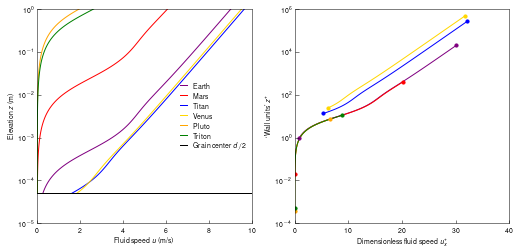

In [10]:
lw = 0.5
S = 10

u_s = 0.3
d = 1e-4

z = np.logspace(np.log10(d/2),0,100)

fig = plt.gcf()

ax0 = plt.subplot(121)

for i in range(Nn): 
    u = u_calc_guo(z,u_s,d,np.mean(nu[i]))
    ax0.plot(u,z,lw=lw*2,c=color[i],label=name[i])
ax0.plot([0,10],[d/2,d/2],c='k',lw=lw*2,label='Grain center $d/2$')
ax0.set_yscale('log')
ax0.set_ylim(1e-5,1)
ax0.set_xlim(0,10)
ax0.set_xlabel('Fluid speed $u$ (m/s)',fontsize=fs)
ax0.set_ylabel('Elevation $z$ (m)',fontsize=fs)
ax0.legend(frameon=False,loc=5,fontsize=fs,handlelength=lw*2,ncol=1)

ax0.set_yticks([1e-5,1e-4,1e-3,1e-2,1e-1,1e+0])
ax0.set_yticklabels(['$10^{-5}$','$10^{-4}$','$10^{-3}$','$10^{-2}$','$10^{-1}$','$10^{0}$'],fontsize=fs)
ax0.set_xticks([0,2,4,6,8,10])
ax0.set_xticklabels(['$0$','$2$','$4$','$6$','$8$','$10$'],fontsize=fs)
plt.minorticks_off()

ax1 = plt.subplot(122)

for i in range(Nn): 
    u = u_calc_guo(z,u_s,d,np.mean(nu[i]))
    ax1.plot(u/u_s,z*u_s/np.mean(nu[i]),lw=lw*2,c=color[i],label=name[i],zorder=-1)
    ax1.scatter(u[0]/u_s,z[0]*u_s/np.mean(nu[i]),s=S,c=color[i])
    ax1.scatter(u[-1]/u_s,z[-1]*u_s/np.mean(nu[i]),s=S,c=color[i])
ax1.set_yscale('log')
ax1.set_ylim(1e-4,1e+6)
ax1.set_xlim(0,40)
ax1.set_xlabel('Dimensionless fluid speed $u_x^+$',fontsize=fs)
ax1.set_ylabel('`Wall units\' $z^+$',fontsize=fs)

ax1.set_yticks([1e-4,1e-2,1e-0,1e+2,1e+4,1e+6])
ax1.set_yticklabels(['$10^{-4}$','$10^{-2}$','$10^{0}$','$10^{2}$','$10^{4}$','$10^{6}$'],fontsize=fs)
ax1.set_xticks([0,10,20,30,40])
ax1.set_xticklabels(['$0$','$10$','$20$','$30$','$40$'],fontsize=fs)
plt.minorticks_off()

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 

fig.subplots_adjust(wspace=0.2)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(bottom=0.1)
fig.subplots_adjust(top=0.95)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(left=0.07)

fig.set_size_inches(183./25.4, 89/25.4, forward=True)
# plt.savefig('exfig1-rough.pdf', dpi=300)

In [11]:
# this is created with data from other papers identifying the
# fluid threshold for motion with reported humidites less than 15%
# if temperature is not reported, it is assumed to be 293.15 K
# gravity is assumed to be 9.81
# field studies have the tunnel height set to -9999
# assumed glass density to be 2500 for mckenna-neuman (2008)
# assumed air density from elevation where T,p was missing from standard atmosphere experiments
# assumed hamaker constants from isrealachvilli, yu2017, and "Hamaker constants of inorganic materials" Lennart Bergstr6m 1997
# assumed copper, copper oxide and bronze were all copper for hamaker constants
# assumed clover seed, lycopodium and instant tea were same as walnut shells
# assumed coal and charcoal were around any of the CHO complex values in table 13.2 isreaichvilli of 5e-20
# assume plaster of paris is gypsum plaster
# could not find sugar anywhere, assumed 5e-20
# used table 2 values for clay in A Simple Experimental Way of Measuring the Hamaker Constant A11 of Divided Solids by Immersion Calorimetry in Apolar Liquids Vincent Médout-Marère 2000

tempdata    = pd.read_csv('SI_table3.csv',header=1)
u_s_obs     = np.asarray(tempdata.iloc[:,1])
d_opp       = np.asarray(tempdata.iloc[:,0])
rho_f_opp   = np.asarray(tempdata.iloc[:,4])
rho_s_opp   = np.asarray(tempdata.iloc[:,5])
A_opp       = np.asarray(tempdata.iloc[:,7])
nu_opp      = np.asarray(tempdata.iloc[:,8])
T_opp       = np.asarray(tempdata.iloc[:,9])
g_opp       = np.asarray(tempdata.iloc[:,10])
gamma_opp   = np.asarray(tempdata.iloc[:,11])
M_opp       = np.asarray(tempdata.iloc[:,12])*1e-3 #g/mol to kg/mol
ref_opp     = np.asarray(tempdata.iloc[:,19])
reffull_opp = np.asarray(tempdata.iloc[:,20])

ofnoterefs = ['swann2020','greeley1976','greeley1980','iversen1976','burr2015','greeley1984','marshall1992','merrison2007','greeley1974','burr2020']
uniquerefs = np.unique(ref_opp)
uniquerefsfull = np.unique(reffull_opp)
colors  = ['r','g','b','c','m','y','k']
markers = ['o','s','D','v','p']

In [12]:
fit = least_squares(find_ab,[1,10],args=[u_s_obs,d_opp,rho_f_opp,rho_s_opp,A_opp,nu_opp,T_opp,g_opp,gamma_opp,M_opp],verbose=2)
A0fit, B0fit = fit.x
print(A0fit, B0fit)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.6894e+01                                    4.87e+01    
       1              2         2.7765e+01      1.91e+01       1.19e+00       9.93e-01    
       2              3         2.7720e+01      4.48e-02       1.02e-01       9.13e-01    
       3              5         2.7720e+01      1.62e-04       2.74e-03       4.05e-01    
       4              6         2.7720e+01      1.10e-04       6.84e-04       1.67e-01    
       5              7         2.7720e+01      1.15e-04       6.84e-04       1.55e-01    
       6              8         2.7720e+01      1.97e-04       1.37e-03       1.43e-01    
       7              9         2.7719e+01      3.57e-04       2.74e-03       1.08e-01    
       8             10         2.7719e+01      3.95e-04       5.47e-03       4.01e-01    
       9             19         2.7719e+01      3.42e-09       3.88e-08       1.11e-01    

In [13]:
fit = least_squares(find_b,[10],args=[u_s_obs,d_opp,rho_f_opp,rho_s_opp,A_opp,nu_opp,T_opp,g_opp,gamma_opp,M_opp],verbose=2)
B1fit = fit.x[0]
A1fit = 1
print(A1fit, B1fit)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.6894e+01                                    3.36e+01    
       1              2         2.7748e+01      1.91e+01       1.21e+00       1.00e+00    
       2              3         2.7723e+01      2.47e-02       5.63e-02       8.45e-03    
       3             11         2.7723e+01      0.00e+00       0.00e+00       8.45e-03    
`xtol` termination condition is satisfied.
Function evaluations 11, initial cost 4.6894e+01, final cost 2.7723e+01, first-order optimality 8.45e-03.
1 8.73660309227075


In [14]:
u_s_pred0 = np.empty(len(u_s_obs))
u_s_pred1 = np.empty(len(u_s_obs))
for i in range(len(u_s_obs)):
    u_s_pred0[i] = find_us_fl(A0fit,B0fit,d_opp[i],rho_f_opp[i],rho_s_opp[i],A_opp[i],nu_opp[i],T_opp[i],g_opp[i],gamma_opp[i],M_opp[i])
    u_s_pred1[i] = find_us_fl(A1fit,B1fit,d_opp[i],rho_f_opp[i],rho_s_opp[i],A_opp[i],nu_opp[i],T_opp[i],g_opp[i],gamma_opp[i],M_opp[i])

In [15]:
u_s_pred_iverson = us_calc_iverson(d_opp,g_opp,rho_s_opp,rho_f_opp,nu_opp)
u_s_pred_shao = us_calc_shao(d_opp,g_opp,rho_s_opp,rho_f_opp)

r_iverson = pearsonr(np.log(u_s_pred_iverson),np.log(u_s_obs))[0]
r_shao = pearsonr(np.log(u_s_pred_shao),np.log(u_s_obs))[0]
r_0fitted = pearsonr(np.log(u_s_pred0),np.log(u_s_obs))[0]
r_1fitted = pearsonr(np.log(u_s_pred1),np.log(u_s_obs))[0]

print(r_iverson**2,r_shao**2,r_0fitted**2,r_1fitted**2)

0.9606081586586224 0.9568651893848271 0.9464112715563219 0.946412007348843


In [16]:
s_opp = rho_s_opp/rho_f_opp
Ga_opp = (d_opp**3.*g_opp*(s_opp-1.))**0.5/nu_opp

<ipython-input-17-bcc90ff0638c>:102: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax4.set_xscale('log')
<ipython-input-17-bcc90ff0638c>:103: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax4.set_yscale('log')


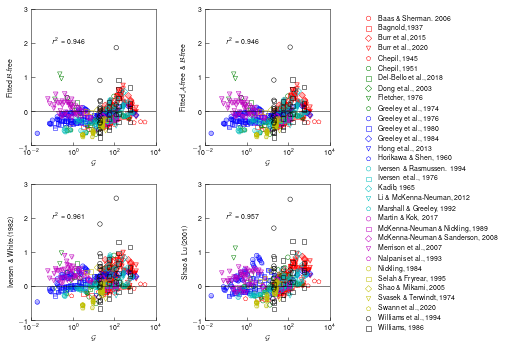

In [17]:
fig = plt.gcf()

S = 20
lw = 0.5
Alpha = 0.3

ax0 = plt.subplot(231)

for i in range(len(colors)):
    for j in range(len(markers)):
        if i*len(markers)+j<len(uniquerefs):
            temp = np.argwhere(ref_opp==uniquerefs[i*len(markers)+j])
            if uniquerefs[i*len(markers)+j] in ofnoterefs:
                ax0.scatter(Ga_opp[temp],u_s_obs[temp]/u_s_pred1[temp]-1,s=S,color=colors[i],alpha=Alpha,lw=0,edgecolor=colors[i],marker=markers[j])
            ax0.scatter(Ga_opp[temp],u_s_obs[temp]/u_s_pred1[temp]-1,s=S,color='none',edgecolor=colors[i],lw=lw,marker=markers[j])
ax0.text(1e-1,2,'$r^2 = %.3f$'%r_1fitted**2.,fontsize=fs)
ax0.plot([1e-2,1e+4],[0,0],'k',lw=lw)
ax0.set_xscale('log')
ax0.set_xlim(1e-2,1e+4)
ax0.set_ylim(-1,3)
ax0.set_xlabel('$\\mathcal{G}$',fontsize=fs)
ax0.set_ylabel('Fitted $\\mathcal{B}$-free',fontsize=fs)
ax0.set_yticks([-1,0,1,2,3])
ax0.set_yticklabels(['$-1$','$0$','$1$','$2$','$3$'],fontsize=fs)
ax0.set_xticks([1e-2,1e+0,1e+2,1e+4])
ax0.set_xticklabels(['$10^{-2}$','$10^{0}$','$10^{2}$','$10^{4}$'],fontsize=fs)
plt.minorticks_off()

ax1 = plt.subplot(232)

for i in range(len(colors)):
    for j in range(len(markers)):
        if i*len(markers)+j<len(uniquerefs):
            temp = np.argwhere(ref_opp==uniquerefs[i*len(markers)+j])
            if uniquerefs[i*len(markers)+j] in ofnoterefs:
                ax1.scatter(Ga_opp[temp],u_s_obs[temp]/u_s_pred0[temp]-1,s=S,color=colors[i],alpha=Alpha,lw=0,edgecolor=colors[i],marker=markers[j])
            ax1.scatter(Ga_opp[temp],u_s_obs[temp]/u_s_pred0[temp]-1,s=S,color='none',edgecolor=colors[i],lw=lw,marker=markers[j])
ax1.text(1e-1,2,'$r^2 = %.3f$'%r_0fitted**2.,fontsize=fs)
ax1.plot([1e-2,1e+4],[0,0],'k',lw=lw)
ax1.set_xscale('log')
ax1.set_xlim(1e-2,1e+4)
ax1.set_ylim(-1,3)
ax1.set_xlabel('$\\mathcal{G}$',fontsize=fs)
ax1.set_ylabel('Fitted $\\mathcal{A}$-free \& $\\mathcal{B}$-free',fontsize=fs)
ax1.set_yticks([-1,0,1,2,3])
ax1.set_yticklabels(['$-1$','$0$','$1$','$2$','$3$'],fontsize=fs)
ax1.set_xticks([1e-2,1e+0,1e+2,1e+4])
ax1.set_xticklabels(['$10^{-2}$','$10^{0}$','$10^{2}$','$10^{4}$'],fontsize=fs)
plt.minorticks_off()

ax2 = plt.subplot(234)

for i in range(len(colors)):
    for j in range(len(markers)):
        if i*len(markers)+j<len(uniquerefs):
            temp = np.argwhere(ref_opp==uniquerefs[i*len(markers)+j])
            if uniquerefs[i*len(markers)+j] in ofnoterefs:
                ax2.scatter(Ga_opp[temp],u_s_obs[temp]/u_s_pred_iverson[temp]-1,s=S,color=colors[i],alpha=Alpha,lw=0,edgecolor=colors[i],marker=markers[j])
            ax2.scatter(Ga_opp[temp],u_s_obs[temp]/u_s_pred_iverson[temp]-1,s=S,color='none',edgecolor=colors[i],lw=lw,marker=markers[j])
ax2.text(1e-1,2,'$r^2 = %.3f$'%r_iverson**2.,fontsize=fs)
ax2.plot([1e-2,1e+4],[0,0],'k',lw=lw)
ax2.set_xscale('log')
ax2.set_xlim(1e-2,1e+4)
ax2.set_ylim(-1,3)
ax2.set_xlabel('$\\mathcal{G}$',fontsize=fs)
ax2.set_ylabel('Iversen \& White (1982)',fontsize=fs)
ax2.set_yticks([-1,0,1,2,3])
ax2.set_yticklabels(['$-1$','$0$','$1$','$2$','$3$'],fontsize=fs)
ax2.set_xticks([1e-2,1e+0,1e+2,1e+4])
ax2.set_xticklabels(['$10^{-2}$','$10^{0}$','$10^{2}$','$10^{4}$'],fontsize=fs)
plt.minorticks_off()

ax3 = plt.subplot(235)

for i in range(len(colors)):
    for j in range(len(markers)):
        if i*len(markers)+j<len(uniquerefs):
            temp = np.argwhere(ref_opp==uniquerefs[i*len(markers)+j])
            if uniquerefs[i*len(markers)+j] in ofnoterefs:
                ax3.scatter(Ga_opp[temp],u_s_obs[temp]/u_s_pred_shao[temp]-1,s=S,color=colors[i],alpha=Alpha,lw=0,edgecolor=colors[i],marker=markers[j])
            ax3.scatter(Ga_opp[temp],u_s_obs[temp]/u_s_pred_shao[temp]-1,s=S,color='none',edgecolor=colors[i],lw=lw,marker=markers[j],label=uniquerefs[i*len(markers)+j])
ax3.text(1e-1,2,'$r^2 = %.3f$'%r_shao**2.,fontsize=fs)
ax3.plot([1e-2,1e+4],[0,0],'k',lw=lw)
ax3.set_xscale('log')
ax3.set_xlim(1e-2,1e+4)
ax3.set_ylim(-1,3)
ax3.set_xlabel('$\\mathcal{G}$',fontsize=fs)
ax3.set_ylabel('Shao \& Lu (2001)',fontsize=fs)
ax3.set_yticks([-1,0,1,2,3])
ax3.set_yticklabels(['$-1$','$0$','$1$','$2$','$3$'],fontsize=fs)
ax3.set_xticks([1e-2,1e+0,1e+2,1e+4])
ax3.set_xticklabels(['$10^{-2}$','$10^{0}$','$10^{2}$','$10^{4}$'],fontsize=fs)
plt.minorticks_off()

ax4 = plt.subplot(233)

for i in range(len(colors)):
    for j in range(len(markers)):
        if i*len(markers)+j<len(uniquerefs):
            temp = np.argwhere(ref_opp==uniquerefs[i*len(markers)+j])
            ax4.scatter(u_s_obs[temp]*-1,u_s_pred_shao[temp]*-1,s=S,color='none',edgecolor=colors[i],lw=lw,marker=markers[j],label=uniquerefsfull[i*len(markers)+j])
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlim(1e-2,1e+1)
ax4.set_ylim(1e-2,1e+1)
ax4.axis('off')
ax4.legend(frameon=False,fontsize=fs,handlelength=lw*2,ncol=1)

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw) 
ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw) 
    
fig.subplots_adjust(wspace=0.4)
fig.subplots_adjust(hspace=0.28)
fig.subplots_adjust(bottom=0.08)
fig.subplots_adjust(top=0.98)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(left=0.07)

fig.set_size_inches(183./25.4, 183./1.5/25.4, forward=True)
# plt.savefig('exfig2-rough.pdf', dpi=300)

In [18]:
us_fl = []

Nd = 30
d = np.logspace(-5,-2,Nd)

for i in range(Nn):
    us_flTEMP = []
    for j in range(len(sediment[i])):
        us_fltemp = np.empty((NT,Np,Nd))
        for k in range(NT):
            for l in range(Np):
                for m in np.arange(Nd-1,-1,-1):
                    if m==Nd-1:
                        us_fltemp[k,l,m] = find_us_fl(A1fit,B1fit,d[m],rho_f[i][k,l],rho_s[i][j],A[i][j][k,l],nu[i,k,l],T_x[i,k],g[i],gamma[i],M[i])
                    else:
                        us_fltemp[k,l,m] = find_us_fl(A1fit,B1fit,d[m],rho_f[i][k,l],rho_s[i][j],A[i][j][k,l],nu[i,k,l],T_x[i,k],g[i],gamma[i],M[i],us_fltemp[k,l,m+1])
        print(name[i],sediment[i][j])
        us_flTEMP.append(us_fltemp)
    us_fl.append(us_flTEMP)


Earth Quartz
Earth Gypsum
Mars Basalt
Mars Quartz
Titan Tholin (Dense)
Titan Tholin (Light)
Titan Water Ice


/home/andle/.local/lib/python3.8/site-packages/scipy/optimize/nonlin.py:472: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))


Venus Basalt
Venus Quartz
Pluto Methane Ice
Pluto Nitrogen Ice
Triton Tholin (Dense)
Triton Tholin (Light)
Triton Methane Ice
Triton Nitrogen Ice


In [19]:
# with open('fluid_threshold_pred.pkl', 'wb') as tempfile:
#     pickle.dump((us_fl,A1fit,B1fit,rho_f,rho_s,A,nu,T_x,g,gamma,M,d), tempfile)

In [20]:
with open('fluid_threshold_pred.pkl', 'rb') as tempfile:
    us_fl,A1fit,B1fit,rho_f,rho_s,A,nu,T_x,g,gamma,M,d = pickle.load(tempfile)

In [21]:
us_fl_min = []
us_fl_max = []

for i in range(Nn):
    us_fl_minTEMP = []
    us_fl_maxTEMP = []
    for j in range(len(sediment[i])):
        us_fl_mintemp = np.empty(Nd)
        us_fl_maxtemp = np.empty(Nd)
        for m in range(Nd):
            us_fl_mintemp[m] = np.min(us_fl[i][j][:,:,m])
            us_fl_maxtemp[m] = np.max(us_fl[i][j][:,:,m])
        us_fl_minTEMP.append(us_fl_mintemp)
        us_fl_maxTEMP.append(us_fl_maxtemp)
    us_fl_min.append(us_fl_minTEMP)
    us_fl_max.append(us_fl_maxTEMP)

In [22]:
Ma = []
Kn = []
for i in range(Nn):
    MaTEMP = []
    KnTEMP = []
    for j in range(len(sediment[i])):
        Matemp = u_calc_guo(d[np.newaxis,np.newaxis,:]/2.,us_fl[i][j],d[np.newaxis,np.newaxis,:],nu[i][:,:,np.newaxis])/(gamma[i]*R*T_x[i][:,np.newaxis,np.newaxis]/M[i])**0.5
        Kntemp = nu[i][:,:,np.newaxis]/d[np.newaxis,np.newaxis,:]*(M[i]*np.pi/2./R/T_x[i][:,np.newaxis,np.newaxis])**0.5
        MaTEMP.append(Matemp)
        KnTEMP.append(Kntemp)
    Ma.append(MaTEMP)
    Kn.append(KnTEMP)

Ma_min = []
Ma_max = []
Kn_min = []
Kn_max = []

for i in range(Nn):
    Ma_minTEMP = []
    Ma_maxTEMP = []    
    Kn_minTEMP = []
    Kn_maxTEMP = []
    for j in range(len(sediment[i])):
        Ma_mintemp = np.empty(Nd)
        Ma_maxtemp = np.empty(Nd)
        Kn_mintemp = np.empty(Nd)
        Kn_maxtemp = np.empty(Nd)
        for m in range(Nd):
            Ma_mintemp[m] = np.min(Ma[i][j][:,:,m])
            Ma_maxtemp[m] = np.max(Ma[i][j][:,:,m])
            Kn_mintemp[m] = np.min(Kn[i][j][:,:,m])
            Kn_maxtemp[m] = np.max(Kn[i][j][:,:,m])
        Ma_minTEMP.append(Ma_mintemp)
        Ma_maxTEMP.append(Ma_maxtemp)
        Kn_minTEMP.append(Kn_mintemp)
        Kn_maxTEMP.append(Kn_maxtemp)
    Ma_min.append(Ma_minTEMP)
    Ma_max.append(Ma_maxTEMP)
    Kn_min.append(Kn_minTEMP)
    Kn_max.append(Kn_maxTEMP)
    
Ma_opp = u_calc_guo(d_opp/2.,u_s_obs,d_opp,nu_opp)/(gamma_opp*R*T_opp/M_opp)**0.5
Kn_opp = nu_opp/d_opp*(M_opp*np.pi/2./R/T_opp)**0.5

In [23]:
Kn_temp = np.logspace(-8,2,32)
Ma_temp = np.logspace(-5,1,30)

Cd_temp = np.empty((len(Kn_temp),len(Ma_temp)))

gamma_temp = 1.4

for i in range(len(Kn_temp)):
    for j in range(len(Ma_temp)):
        Cd_temp[i,j] = Cd_calc_loth(Ma_temp[j]/Kn_temp[i]*(np.pi*gamma_temp/2.)**0.5,Ma_temp[j],gamma_temp)

In [24]:
s_opp = rho_s_opp/rho_f_opp
Cd_opp = Cd_calc_loth(Ma_opp/Kn_opp*(np.pi*gamma_opp/2.)**0.5,Ma_opp,gamma_opp)
Cl_opp = Cl_calc_loth(d_opp,u_s_obs,nu_opp)
up_opp = u_calc_guo(d_opp/2.,u_s_obs,d_opp,nu_opp)
sg_opp = A_opp/12./np.pi/d0**2. # surface energy, surface gamma
Th_opp = up_opp**2./g_opp/d_opp/(s_opp-1.)
Ph_opp = up_opp**2.*d_opp*rho_f_opp/sg_opp
alpha_opp = 4./3./A1fit/(2.*2.**0.5*Cd_opp+Cl_opp)
beta_opp  = 4.*6.**0.5*np.exp(-B1fit)/A1fit/(2.*2.**0.5*Cd_opp+Cl_opp)

Sh_opp = u_s_obs**2./g_opp/d_opp/(s_opp-1.)
Ga_opp = ((s_opp-1.)*g_opp*d_opp**3.)**0.5/nu_opp

Sh = []
Garoots = []
for i in range(Nn):
    ShTEMP = []
    GarootsTEMP = []
    for j in range(len(sediment[i])):
        Shtemp = us_fl[i][j]**2./g[i]/d[np.newaxis,np.newaxis,:]/(rho_s[i][j]/rho_f[i][:,:,np.newaxis]-1.)
        Garootstemp = ((rho_s[i][j]/rho_f[i][:,:,np.newaxis]-1.)*g[i]*d[np.newaxis,np.newaxis,:]**3.)**0.5/nu[i][:,:,np.newaxis]*(rho_s[i][j]/rho_f[i][:,:,np.newaxis])**0.5
        ShTEMP.append(Shtemp)
        GarootsTEMP.append(Garootstemp)
    Sh.append(ShTEMP)
    Garoots.append(GarootsTEMP)

Sh_min = []
Sh_max = []
Garoots_min = []
Garoots_max = []

for i in range(Nn):
    Sh_minTEMP = []
    Sh_maxTEMP = []    
    Garoots_minTEMP = []
    Garoots_maxTEMP = []
    for j in range(len(sediment[i])):
        Sh_mintemp = np.empty(Nd)
        Sh_maxtemp = np.empty(Nd)
        Garoots_mintemp = np.empty(Nd)
        Garoots_maxtemp = np.empty(Nd)
        for m in range(Nd):
            Sh_mintemp[m] = np.min(Sh[i][j][:,:,m])
            Sh_maxtemp[m] = np.max(Sh[i][j][:,:,m])
            Garoots_mintemp[m] = np.min(Garoots[i][j][:,:,m])
            Garoots_maxtemp[m] = np.max(Garoots[i][j][:,:,m])
        Sh_minTEMP.append(Sh_mintemp)
        Sh_maxTEMP.append(Sh_maxtemp)
        Garoots_minTEMP.append(Garoots_mintemp)
        Garoots_maxTEMP.append(Garoots_maxtemp)
    Sh_min.append(Sh_minTEMP)
    Sh_max.append(Sh_maxTEMP)
    Garoots_min.append(Garoots_minTEMP)
    Garoots_max.append(Garoots_maxTEMP)

In [25]:
Kn_temp = np.logspace(-8,2,82)
Ma_temp = np.logspace(-5,1,80)

Cd_temp = np.empty((len(Kn_temp),len(Ma_temp)))

gamma_temp = 1.4

for i in range(len(Kn_temp)):
    for j in range(len(Ma_temp)):
        Cd_temp[i,j] = Cd_calc_loth(Ma_temp[j]/Kn_temp[i]*(np.pi*gamma_temp/2.)**0.5,Ma_temp[j],gamma_temp)

In [26]:
Nbin = 25

Bbinsx = np.logspace(-8,2,Nbin)
Bbinsy = np.logspace(-5,1,Nbin)
Bhist = np.histogram2d(Kn_opp,Ma_opp,bins=(Bbinsx,Bbinsy))
Bhist[0][Bhist[0]==0] = np.nan

Ebins = np.logspace(-4,2,Nbin)
Ehist = np.histogram2d(alpha_opp/Th_opp,beta_opp/Ph_opp,bins=Ebins)
Ehist[0][Ehist[0]==0] = np.nan

Cbins = np.logspace(-2,1,Nbin)
Chist = np.histogram2d(u_s_obs,u_s_pred1,bins=Cbins)
Chist[0][Chist[0]==0] = np.nan

<ipython-input-27-88c6a3033581>:84: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  s0 = ax1.pcolormesh(Kn_temp,Ma_temp,np.log10(Cd_temp).T,vmin=0,vmax=5,cmap='binary',rasterized=True)


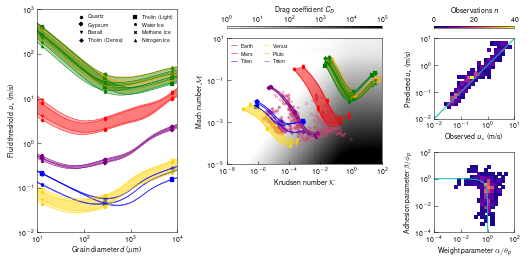

In [27]:
y0temp = 0.54
x0temp = 0.83
sxtemp = 1-x0temp-0.015
sytemp = 0.32
mxtemp = 0.3
mytemp = 0.5
cbarybuff = 0.04
xbuff = 0.1

lw = 0.5
Alpha = 0.3
S = 10
histvmax = np.max([np.nanmax(Chist[0]),np.nanmax(Ehist[0])])
histcolormap = 'plasma'
oppcolor = cm.plasma(0.5)

dus_patches = []
KnMa_patches = []
GarootsSh_patches = []

for i in range(Nn):
    dus_patchestemp = []
    KnMa_patchestemp = []
    GarootsSh_patchestemp = []
    
    for j in range(len(sediment[i])):
 
        d_ij = np.hstack((d*1e+6,np.flip(d*1e+6)))
        us_ij = np.hstack((np.min(np.min(us_fl[i][j],axis=0),axis=0),np.flip(np.max(np.max(us_fl[i][j],axis=0),axis=0))))
        dus_patchestemp.append(PolygonPatch(Polygon(np.vstack((d_ij,us_ij)).T), alpha=Alpha, fc=color[i], ec=color[i], lw=0))

        Kn_ij = np.hstack((np.min(np.min(Kn[i][j],axis=0),axis=0),np.flip(np.max(np.max(Kn[i][j],axis=0),axis=0))))
        Ma_ij = np.hstack((np.min(np.min(Ma[i][j],axis=0),axis=0),np.flip(np.max(np.max(Ma[i][j],axis=0),axis=0))))
        KnMa_patchestemp.append(PolygonPatch(Polygon(np.vstack((Kn_ij,Ma_ij)).T), alpha=Alpha, fc=color[i], ec=color[i], lw=0))

        Garoots_ij = np.hstack((np.min(np.min(Garoots[i][j],axis=0),axis=0),np.flip(np.max(np.max(Garoots[i][j],axis=0),axis=0))))
        Sh_ij = np.hstack((np.min(np.min(Sh[i][j],axis=0),axis=0),np.flip(np.max(np.max(Sh[i][j],axis=0),axis=0))))
        GarootsSh_patchestemp.append(PolygonPatch(Polygon(np.vstack((Garoots_ij,Sh_ij)).T), alpha=Alpha, fc=color[i], ec=color[i], lw=0))
   
    dus_patches.append(dus_patchestemp)    
    KnMa_patches.append(KnMa_patchestemp)
    GarootsSh_patches.append(GarootsSh_patchestemp)

#######

fig = plt.gcf()
    
ax0 = fig.add_axes([0.065, 0.09, 1-(0.01+mxtemp+xbuff+sytemp), 0.885])

for i in range(Nn):
    for j in range(len(sediment[i])):
        
        usmintemp = np.min(np.min(us_fl[i][j],axis=0),axis=0)
        usmaxtemp = np.max(np.max(us_fl[i][j],axis=0),axis=0)
        ax0.plot(d*1e+6,usmintemp,c=color[i],lw=lw)
        ax0.plot(d*1e+6,usmaxtemp,c=color[i],lw=lw)
        ax0.scatter(d[1]*1e+6,usmintemp[1],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
        ax0.scatter(d[-2]*1e+6,usmintemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
        ax0.scatter(d[1]*1e+6,usmaxtemp[1],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
        ax0.scatter(d[-2]*1e+6,usmaxtemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
        ax0.scatter(d[int(Nd/2-1)]*1e+6,usmintemp[int(Nd/2-1)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
        ax0.scatter(d[int(Nd/2-1)]*1e+6,usmaxtemp[int(Nd/2-1)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])

        ax0.add_patch(dus_patches[i][j])
        
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlim(1e+1,1e+4)
ax0.set_ylim(1e-2,1e+3)
ax0.set_xlabel('Grain diameter $d$ ($\\mu$m)',fontsize=fs)
ax0.set_ylabel('Fluid threshold $u_{*}$ (m/s)',fontsize=fs)
ax0.set_xticks([1e+1,1e+2,1e+3,1e+4])
ax0.set_xticklabels(['$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax0.set_yticks([1e-2,1e-1,1e+0,1e+1,1e+2,1e+3])
ax0.set_yticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$','$10^{3}$'],fontsize=fs)
plt.minorticks_off()

for i in range(len(classify_sediments)):
    ax0.scatter([-1],[-1],s=S,c='k',lw=lw/2.,marker=classify_sediments[i][1],label=classify_sediments[i][0])
ax0.legend(frameon=False,fontsize=fs*0.75,handlelength=lw*2,ncol=2)

ax1 = fig.add_axes([x0temp-mxtemp-xbuff, y0temp+sytemp-mytemp, mxtemp, mytemp])

s0 = ax1.pcolormesh(Kn_temp,Ma_temp,np.log10(Cd_temp).T,vmin=0,vmax=5,cmap='binary',rasterized=True)

for i in range(Nn):
    for j in range(len(sediment[i])):
        Knmintemp = np.min(np.min(Kn[i][j],axis=0),axis=0)
        Knmaxtemp = np.max(np.max(Kn[i][j],axis=0),axis=0)
        Mamintemp = np.min(np.min(Ma[i][j],axis=0),axis=0)
        Mamaxtemp = np.max(np.max(Ma[i][j],axis=0),axis=0)
        ax1.plot(Knmintemp,Mamintemp,c=color[i],lw=lw)
        ax1.plot(Knmaxtemp,Mamaxtemp,c=color[i],lw=lw)
        ax1.scatter(Knmintemp[0],Mamintemp[0],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
        ax1.scatter(Knmintemp[-1],Mamintemp[-1],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
        ax1.scatter(Knmaxtemp[0],Mamaxtemp[0],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
        ax1.scatter(Knmaxtemp[-1],Mamaxtemp[-1],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
        ax1.scatter(Knmintemp[int(Nd/2-1)],Mamintemp[int(Nd/2-1)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
        ax1.scatter(Knmaxtemp[int(Nd/2-1)],Mamaxtemp[int(Nd/2-1)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])

        ax1.add_patch(KnMa_patches[i][j])
        
ax1.scatter(Kn_opp,Ma_opp,s=S,color='none',edgecolor=oppcolor,marker='*',lw=lw/2)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-8,1e+2)
ax1.set_ylim(1e-5,1e+1)
ax1.set_xticks([1e-8,1e-6,1e-4,1e-2,1e+0,1e+2])
ax1.set_xticklabels(['$10^{-8}$','$10^{-6}$','$10^{-4}$','$10^{-2}$','$10^{0}$','$10^{2}$'],fontsize=fs)
ax1.set_yticks([1e-5,1e-3,1e-1,1e+1])
ax1.set_yticklabels(['$10^{-5}$','$10^{-3}$','$10^{-1}$','$10^{1}$'],fontsize=fs)
plt.minorticks_off()
ax1.set_xlabel('Knudsen number $\\mathcal{K}$',fontsize=fs)
ax1.set_ylabel('Mach number $\\mathcal{M}$',fontsize=fs)

for i in range(Nn):
    ax1.plot([-1,-1],[-1,-1],c=color[i],lw=lw,label=name[i])
ax1.legend(frameon=False,fontsize=fs*0.75,handlelength=lw*2,ncol=2)



ax2 = fig.add_axes([x0temp, y0temp, sxtemp, sytemp])

ax2.pcolormesh(Chist[1],Chist[2],Chist[0].T,rasterized=True,vmin=0,vmax=histvmax,cmap=histcolormap)
ax2.plot([1e-2,1e+1],[1e-2,1e+1],'c',lw=lw*2)
ax2.set_xscale('log')
ax2.set_yscale('log')
plt.axis('square')
ax2.set_xlim(1e-2,1e+1)
ax2.set_ylim(1e-2,1e+1)
ax2.set_xlabel('Observed $u_{*}$ (m/s)',fontsize=fs)
ax2.set_ylabel('Predicted $u_{*}$ (m/s)',fontsize=fs)
ax2.set_xticks([1e-2,1e-1,1e+0,1e+1])
ax2.set_xticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$'],fontsize=fs)
ax2.set_yticks([1e-2,1e-1,1e+0,1e+1])
ax2.set_yticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$'],fontsize=fs)
plt.minorticks_off()

ax4 = fig.add_axes([x0temp, 0.09, sxtemp, sytemp])

xtemp = np.logspace(-4,np.log10(0.5),40)
s1 = ax4.pcolormesh(Ehist[1],Ehist[2],Ehist[0].T,rasterized=True,vmin=0,vmax=histvmax,cmap=histcolormap)
ax4.plot(xtemp,1-xtemp,'c',lw=lw*2)
ax4.plot(1-xtemp,xtemp,'c',lw=lw*2)
ax4.set_xscale('log')
ax4.set_yscale('log')
plt.axis('square')
ax4.set_xlim(1e-4,1e+2)
ax4.set_ylim(1e-4,1e+2)
ax4.set_xlabel('Weight parameter $\\alpha/\\theta_p$',fontsize=fs)
ax4.set_ylabel('Adhesion parameter $\\beta/\\phi_p$',fontsize=fs)
ax4.set_xticks([1e-4,1e-2,1e+0,1e+2])
ax4.set_xticklabels(['$10^{-4}$','$10^{-2}$','$10^{0}$','$10^{2}$'],fontsize=fs)
ax4.set_yticks([1e-4,1e-2,1e+0,1e+2])
ax4.set_yticklabels(['$10^{-4}$','$10^{-2}$','$10^{0}$','$10^{2}$'],fontsize=fs)
ax4.tick_params('both', width=lw, which='major')
plt.minorticks_off()

fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(bottom=0)
fig.subplots_adjust(top=1)
fig.subplots_adjust(right=1)
fig.subplots_adjust(left=0)

cbar0_ax = fig.add_axes([x0temp-mxtemp-xbuff, y0temp+sytemp+cbarybuff, mxtemp, 0.01])
c0 = fig.colorbar(s0, orientation='horizontal',cax=cbar0_ax, ticks=[0,1,2,3,4,5])
cbar0_ax.xaxis.set_label_position('top')
cbar0_ax.xaxis.set_ticks_position('top')
c0.set_label('Drag coefficient $C_D$',fontsize=fs)
c0.ax.set_xticklabels(['$10^0$','$10^1$','$10^2$','$10^3$','$10^4$','$10^5$'],fontsize=fs)

cbar1_ax = fig.add_axes([x0temp, y0temp+sytemp+cbarybuff, sxtemp, 0.01])
c1 = fig.colorbar(s1, orientation='horizontal',cax=cbar1_ax, ticks=[0,20,40])
cbar1_ax.xaxis.set_label_position('top')
cbar1_ax.xaxis.set_ticks_position('top')
c1.set_label('Observations $n$',fontsize=fs)
c1.ax.set_xticklabels(['$0$','$20$','$40$'],fontsize=fs)


ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw)
ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw)
ax4.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax4.spines[axis].set_linewidth(lw)
c0.ax.tick_params(width=0,which='both',direction='in')
c0.outline.set_linewidth(lw)
c1.ax.tick_params(width=0,which='both',direction='in')
c1.outline.set_linewidth(lw)

fig.set_size_inches(183./25.4, 89/25.4, forward=True)
# plt.savefig('fig2-rough.pdf', dpi=300)

In [28]:
us_fl_mean = []
us_iverson_mean = []
us_shao_mean = []

Nd = 100
d = np.logspace(-5,-2,Nd)

for i in range(Nn):
    us_flTEMP_mean = []
    us_iversonTEMP_mean = []
    us_shaoTEMP_mean = []
    for j in range(len(sediment[i])):
        us_fltemp_mean = np.empty(Nd)
        us_iversontemp_mean = us_calc_iverson(d,g[i]*d/d,rho_s[i][j]*d/d,np.mean(rho_f[i])*d/d,np.mean(nu[i])*d/d)
        us_shaotemp_mean = us_calc_shao(d,g[i],rho_s[i][j],np.mean(rho_f[i]))
        
        for m in np.arange(Nd-1,-1,-1):
            if m==Nd-1:
                us_fltemp_mean[m] = find_us_fl(A1fit,B1fit,d[m],np.mean(rho_f[i]),rho_s[i][j],np.mean(A[i][j]),np.mean(nu[i]),np.mean(T_x[i]),g[i],gamma[i],M[i])
            else:
                us_fltemp_mean[m] = find_us_fl(A1fit,B1fit,d[m],np.mean(rho_f[i]),rho_s[i][j],np.mean(A[i][j]),np.mean(nu[i]),np.mean(T_x[i]),g[i],gamma[i],M[i],us_fltemp_mean[m+1])
        print(name[i],sediment[i][j])
        
        us_flTEMP_mean.append(us_fltemp_mean)
        us_iversonTEMP_mean.append(us_iversontemp_mean)
        us_shaoTEMP_mean.append(us_shaotemp_mean)
    us_fl_mean.append(us_flTEMP_mean)
    us_iverson_mean.append(us_iversonTEMP_mean)
    us_shao_mean.append(us_shaoTEMP_mean)

Earth Quartz
Earth Gypsum
Mars Basalt
Mars Quartz
Titan Tholin (Dense)
Titan Tholin (Light)
Titan Water Ice
Venus Basalt
Venus Quartz
Pluto Methane Ice
Pluto Nitrogen Ice
Triton Tholin (Dense)
Triton Tholin (Light)
Triton Methane Ice
Triton Nitrogen Ice


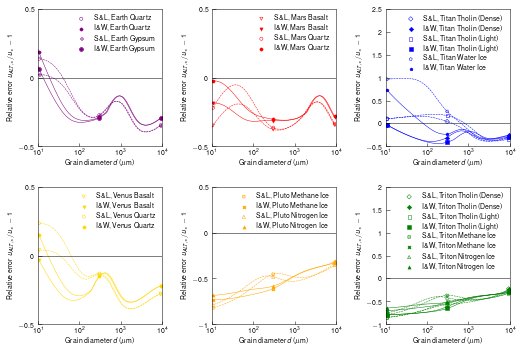

In [29]:
fig = plt.gcf()

S = 10
lw = 0.5
Alpha = 0.3

i = 0
ax0 = plt.subplot(2,3,i+1)
    
for j in range(len(sediment[i])):
    ax0.plot(d*1e+6,us_shao_mean[i][j]/us_fl_mean[i][j]-1,c=color[i],linestyle='--',lw=lw)
    ax0.scatter(d[1]*1e+6,us_shao_mean[i][j][1]/us_fl_mean[i][j][1]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j],label='S\&L, %s %s'%(name[i],sediment[i][j]))
    ax0.scatter(d[-2]*1e+6,us_shao_mean[i][j][-2]/us_fl_mean[i][j][-2]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])
    ax0.scatter(d[int(Nd/2-1)]*1e+6,us_shao_mean[i][j][int(Nd/2-1)]/us_fl_mean[i][j][int(Nd/2-1)]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])    
    
    ax0.plot(d*1e+6,us_iverson_mean[i][j]/us_fl_mean[i][j]-1,c=color[i],linestyle='-',lw=lw)    
    ax0.scatter(d[1]*1e+6,us_iverson_mean[i][j][1]/us_fl_mean[i][j][1]-1,s=S,c=color[i],lw=lw,marker=marker[i][j],label='I\&W, %s %s'%(name[i],sediment[i][j]))
    ax0.scatter(d[-2]*1e+6,us_iverson_mean[i][j][-2]/us_fl_mean[i][j][-2]-1,s=S,c=color[i],lw=lw,marker=marker[i][j])
    ax0.scatter(d[int(Nd/2-1)]*1e+6,us_iverson_mean[i][j][int(Nd/2-1)]/us_fl_mean[i][j][int(Nd/2-1)]-1,s=S,c=color[i],lw=lw,marker=marker[i][j]) 
        
ax0.plot(d*1e+6,0*d,'k',lw=lw)
ax0.set_xscale('log')
ax0.set_xlim(1e+1,1e+4)
ax0.set_ylim(-0.5,0.5)
ax0.set_xlabel('Grain diameter $d$ ($\\mu$m)',fontsize=fs)
ax0.set_ylabel('Relative error $u_{ALT,*}/u_{*}-1$',fontsize=fs)
ax0.set_xticks([1e+1,1e+2,1e+3,1e+4])
ax0.set_xticklabels(['$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax0.set_yticks([-0.5,0,0.5])
ax0.set_yticklabels(['$-0.5$','$0$','$0.5$'],fontsize=fs)
plt.minorticks_off()
plt.legend(frameon=False,fontsize=fs)

i = 1
ax1 = plt.subplot(2,3,i+1)
    
for j in range(len(sediment[i])):
    ax1.plot(d*1e+6,us_shao_mean[i][j]/us_fl_mean[i][j]-1,c=color[i],linestyle='--',lw=lw)
    ax1.scatter(d[1]*1e+6,us_shao_mean[i][j][1]/us_fl_mean[i][j][1]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j],label='S\&L, %s %s'%(name[i],sediment[i][j]))
    ax1.scatter(d[-2]*1e+6,us_shao_mean[i][j][-2]/us_fl_mean[i][j][-2]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])
    ax1.scatter(d[int(Nd/2-1)]*1e+6,us_shao_mean[i][j][int(Nd/2-1)]/us_fl_mean[i][j][int(Nd/2-1)]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])    
    
    ax1.plot(d*1e+6,us_iverson_mean[i][j]/us_fl_mean[i][j]-1,c=color[i],linestyle='-',lw=lw)    
    ax1.scatter(d[1]*1e+6,us_iverson_mean[i][j][1]/us_fl_mean[i][j][1]-1,s=S,c=color[i],lw=lw,marker=marker[i][j],label='I\&W, %s %s'%(name[i],sediment[i][j]))
    ax1.scatter(d[-2]*1e+6,us_iverson_mean[i][j][-2]/us_fl_mean[i][j][-2]-1,s=S,c=color[i],lw=lw,marker=marker[i][j])
    ax1.scatter(d[int(Nd/2-1)]*1e+6,us_iverson_mean[i][j][int(Nd/2-1)]/us_fl_mean[i][j][int(Nd/2-1)]-1,s=S,c=color[i],lw=lw,marker=marker[i][j]) 
        
ax1.plot(d*1e+6,0*d,'k',lw=lw)
ax1.set_xscale('log')
ax1.set_xlim(1e+1,1e+4)
ax1.set_ylim(-0.5,0.5)
ax1.set_xlabel('Grain diameter $d$ ($\\mu$m)',fontsize=fs)
ax1.set_ylabel('Relative error $u_{ALT,*}/u_{*}-1$',fontsize=fs)
ax1.set_xticks([1e+1,1e+2,1e+3,1e+4])
ax1.set_xticklabels(['$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax1.set_yticks([-0.5,0,0.5])
ax1.set_yticklabels(['$-0.5$','$0$','$0.5$'],fontsize=fs)
plt.minorticks_off()
plt.legend(frameon=False,fontsize=fs)

i = 2
ax2 = plt.subplot(2,3,i+1)
    
for j in range(len(sediment[i])):
    ax2.plot(d*1e+6,us_shao_mean[i][j]/us_fl_mean[i][j]-1,c=color[i],linestyle='--',lw=lw)
    ax2.scatter(d[1]*1e+6,us_shao_mean[i][j][1]/us_fl_mean[i][j][1]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j],label='S\&L, %s %s'%(name[i],sediment[i][j]))
    ax2.scatter(d[-2]*1e+6,us_shao_mean[i][j][-2]/us_fl_mean[i][j][-2]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])
    ax2.scatter(d[int(Nd/2-1)]*1e+6,us_shao_mean[i][j][int(Nd/2-1)]/us_fl_mean[i][j][int(Nd/2-1)]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])    
    
    ax2.plot(d*1e+6,us_iverson_mean[i][j]/us_fl_mean[i][j]-1,c=color[i],linestyle='-',lw=lw)    
    ax2.scatter(d[1]*1e+6,us_iverson_mean[i][j][1]/us_fl_mean[i][j][1]-1,s=S,c=color[i],lw=lw,marker=marker[i][j],label='I\&W, %s %s'%(name[i],sediment[i][j]))
    ax2.scatter(d[-2]*1e+6,us_iverson_mean[i][j][-2]/us_fl_mean[i][j][-2]-1,s=S,c=color[i],lw=lw,marker=marker[i][j])
    ax2.scatter(d[int(Nd/2-1)]*1e+6,us_iverson_mean[i][j][int(Nd/2-1)]/us_fl_mean[i][j][int(Nd/2-1)]-1,s=S,c=color[i],lw=lw,marker=marker[i][j]) 
        
ax2.plot(d*1e+6,0*d,'k',lw=lw)
ax2.set_xscale('log')
ax2.set_xlim(1e+1,1e+4)
ax2.set_ylim(-0.5,2.5)
ax2.set_xlabel('Grain diameter $d$ ($\\mu$m)',fontsize=fs)
ax2.set_ylabel('Relative error $u_{ALT,*}/u_{*}-1$',fontsize=fs)
ax2.set_xticks([1e+1,1e+2,1e+3,1e+4])
ax2.set_xticklabels(['$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax2.set_yticks([-0.5,0,0.5,1,1.5,2,2.5])
ax2.set_yticklabels(['$-0.5$','$0$','$0.5$','$1$','$1.5$','$2$','$2.5$'],fontsize=fs)
plt.minorticks_off()
plt.legend(frameon=False,fontsize=fs)

i = 3
ax3 = plt.subplot(2,3,i+1)
    
for j in range(len(sediment[i])):
    ax3.plot(d*1e+6,us_shao_mean[i][j]/us_fl_mean[i][j]-1,c=color[i],linestyle='--',lw=lw)
    ax3.scatter(d[1]*1e+6,us_shao_mean[i][j][1]/us_fl_mean[i][j][1]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j],label='S\&L, %s %s'%(name[i],sediment[i][j]))
    ax3.scatter(d[-2]*1e+6,us_shao_mean[i][j][-2]/us_fl_mean[i][j][-2]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])
    ax3.scatter(d[int(Nd/2-1)]*1e+6,us_shao_mean[i][j][int(Nd/2-1)]/us_fl_mean[i][j][int(Nd/2-1)]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])    
    
    ax3.plot(d*1e+6,us_iverson_mean[i][j]/us_fl_mean[i][j]-1,c=color[i],linestyle='-',lw=lw)    
    ax3.scatter(d[1]*1e+6,us_iverson_mean[i][j][1]/us_fl_mean[i][j][1]-1,s=S,c=color[i],lw=lw,marker=marker[i][j],label='I\&W, %s %s'%(name[i],sediment[i][j]))
    ax3.scatter(d[-2]*1e+6,us_iverson_mean[i][j][-2]/us_fl_mean[i][j][-2]-1,s=S,c=color[i],lw=lw,marker=marker[i][j])
    ax3.scatter(d[int(Nd/2-1)]*1e+6,us_iverson_mean[i][j][int(Nd/2-1)]/us_fl_mean[i][j][int(Nd/2-1)]-1,s=S,c=color[i],lw=lw,marker=marker[i][j]) 
        
ax3.plot(d*1e+6,0*d,'k',lw=lw)
ax3.set_xscale('log')
ax3.set_xlim(1e+1,1e+4)
ax3.set_ylim(-0.5,0.5)
ax3.set_xlabel('Grain diameter $d$ ($\\mu$m)',fontsize=fs)
ax3.set_ylabel('Relative error $u_{ALT,*}/u_{*}-1$',fontsize=fs)
ax3.set_xticks([1e+1,1e+2,1e+3,1e+4])
ax3.set_xticklabels(['$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax3.set_yticks([-0.5,0,0.5])
ax3.set_yticklabels(['$-0.5$','$0$','$0.5$'],fontsize=fs)
plt.minorticks_off()
plt.legend(frameon=False,fontsize=fs)

i = 4
ax4 = plt.subplot(2,3,i+1)
    
for j in range(len(sediment[i])):
    ax4.plot(d*1e+6,us_shao_mean[i][j]/us_fl_mean[i][j]-1,c=color[i],linestyle='--',lw=lw)
    ax4.scatter(d[1]*1e+6,us_shao_mean[i][j][1]/us_fl_mean[i][j][1]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j],label='S\&L, %s %s'%(name[i],sediment[i][j]))
    ax4.scatter(d[-2]*1e+6,us_shao_mean[i][j][-2]/us_fl_mean[i][j][-2]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])
    ax4.scatter(d[int(Nd/2-1)]*1e+6,us_shao_mean[i][j][int(Nd/2-1)]/us_fl_mean[i][j][int(Nd/2-1)]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])    

    ax4.plot(d*1e+6,us_iverson_mean[i][j]/us_fl_mean[i][j]-1,c=color[i],linestyle='-',lw=lw)    
    ax4.scatter(d[1]*1e+6,us_iverson_mean[i][j][1]/us_fl_mean[i][j][1]-1,s=S,c=color[i],lw=lw,marker=marker[i][j],label='I\&W, %s %s'%(name[i],sediment[i][j]))
    ax4.scatter(d[-2]*1e+6,us_iverson_mean[i][j][-2]/us_fl_mean[i][j][-2]-1,s=S,c=color[i],lw=lw,marker=marker[i][j])
    ax4.scatter(d[int(Nd/2-1)]*1e+6,us_iverson_mean[i][j][int(Nd/2-1)]/us_fl_mean[i][j][int(Nd/2-1)]-1,s=S,c=color[i],lw=lw,marker=marker[i][j]) 
        
ax4.plot(d*1e+6,0*d,'k',lw=lw)
ax4.set_xscale('log')
ax4.set_xlim(1e+1,1e+4)
ax4.set_ylim(-1,0.5)
ax4.set_xlabel('Grain diameter $d$ ($\\mu$m)',fontsize=fs)
ax4.set_ylabel('Relative error $u_{ALT,*}/u_{*}-1$',fontsize=fs)
ax4.set_xticks([1e+1,1e+2,1e+3,1e+4])
ax4.set_xticklabels(['$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax4.set_yticks([-1,-0.5,0,0.5])
ax4.set_yticklabels(['$-1$','$-0.5$','$0$','$0.5$'],fontsize=fs)
plt.minorticks_off()
plt.legend(frameon=False,fontsize=fs,loc=1)

i = 5
ax5 = plt.subplot(2,3,i+1)
    
for j in range(len(sediment[i])):
    ax5.plot(d*1e+6,us_shao_mean[i][j]/us_fl_mean[i][j]-1,c=color[i],linestyle='--',lw=lw)
    ax5.scatter(d[1]*1e+6,us_shao_mean[i][j][1]/us_fl_mean[i][j][1]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j],label='S\&L, %s %s'%(name[i],sediment[i][j]))
    ax5.scatter(d[-2]*1e+6,us_shao_mean[i][j][-2]/us_fl_mean[i][j][-2]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])
    ax5.scatter(d[int(Nd/2-1)]*1e+6,us_shao_mean[i][j][int(Nd/2-1)]/us_fl_mean[i][j][int(Nd/2-1)]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])    

    ax5.plot(d*1e+6,us_iverson_mean[i][j]/us_fl_mean[i][j]-1,c=color[i],linestyle='-',lw=lw)    
    ax5.scatter(d[1]*1e+6,us_iverson_mean[i][j][1]/us_fl_mean[i][j][1]-1,s=S,c=color[i],lw=lw,marker=marker[i][j],label='I\&W, %s %s'%(name[i],sediment[i][j]))
    ax5.scatter(d[-2]*1e+6,us_iverson_mean[i][j][-2]/us_fl_mean[i][j][-2]-1,s=S,c=color[i],lw=lw,marker=marker[i][j])
    ax5.scatter(d[int(Nd/2-1)]*1e+6,us_iverson_mean[i][j][int(Nd/2-1)]/us_fl_mean[i][j][int(Nd/2-1)]-1,s=S,c=color[i],lw=lw,marker=marker[i][j]) 
        
ax5.plot(d*1e+6,0*d,'k',lw=lw)
ax5.set_xscale('log')
ax5.set_xlim(1e+1,1e+4)
ax5.set_ylim(-1,2)
ax5.set_xlabel('Grain diameter $d$ ($\\mu$m)',fontsize=fs)
ax5.set_ylabel('Relative error $u_{ALT,*}/u_{*}-1$',fontsize=fs)
ax5.set_xticks([1e+1,1e+2,1e+3,1e+4])
ax5.set_xticklabels(['$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax5.set_yticks([-1,-0.5,0,0.5,1,1.5,2])
ax5.set_yticklabels(['$-1$','$-0.5$','$0$','$0.5$','$1$','$1.5$','$2$'],fontsize=fs)
plt.minorticks_off()
plt.legend(frameon=False,fontsize=fs,loc=1)

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw) 
ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw) 
ax4.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax4.spines[axis].set_linewidth(lw)
ax5.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax5.spines[axis].set_linewidth(lw)
    
fig.subplots_adjust(wspace=0.4)
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(bottom=0.07)
fig.subplots_adjust(top=0.98)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(left=0.07)

fig.set_size_inches(183./25.4, 183./1.5/25.4, forward=True)
# plt.savefig('exfig3-rough.pdf', dpi=300)